# Urgency Dataset

In [7]:
# read the csv data in the google sheets and gather all of the sentences  
import pandas as pd


dataset = pd.read_csv("../UrgencySentenceSamples.csv", encoding="utf-8") 
ohe = pd.get_dummies(dataset["Label"])
dataset = pd.concat([dataset["Sentence"], ohe], axis=1)
dataset.head(5)

,Sentence,critical,info,warning
0,As of today 60 people went missing on the park,1,0,0
1,The biker was injured on the street and now is...,1,0,0
2,The president has been kidnapped by terrorists,1,0,0
3,People in Louisiana are in dire need of food a...,1,0,0
4,Five cars were hit and are now stranded beneat...,1,0,0


In [8]:
# pre-process text 
import nltk
nltk.download('omw-1.4')
import re 
from nltk.corpus import stopwords
import string
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

lines = dataset['Sentence'].values.tolist()

def text_normalization(lines):
    cleaned_data = []
    for line in lines: 
      line = line.lower()
      line = re.sub(r'[^\w\s]', '', line)
      words = word_tokenize(line) 
      cleaned_line = [word for word in words if not word in set(stopwords.words('english'))] 
      cleaned_line = [WordNetLemmatizer().lemmatize(word) for word in cleaned_line] 
      #cleaned_line_text = ' '.join([str(word) for word in cleaned_line])
      cleaned_data.append(cleaned_line)
    
    return cleaned_data
  
cleaned_data = text_normalization(lines)
print(cleaned_data)


[nltk_data] Downloading package omw-1.4 to /Users/aszeto1/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aszeto1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aszeto1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aszeto1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['today', '60', 'people', 'went', 'missing', 'park'], ['biker', 'injured', 'street', 'critical', 'need', 'medical', 'attention'], ['president', 'kidnapped', 'terrorist'], ['people', 'louisiana', 'dire', 'need', 'food', 'hurricane', 'destroyed', 'home'], ['five', 'car', 'hit', 'stranded', 'beneath', 'cliff'], ['must', 'immediately', 'stop', 'dog', 'attacking', 'child'], ['brother', 'critical', 'condition', 'injury'], ['eat', 'food', 'next', 'day', 'die'], ['son', 'lost', 'need', 'find', 'urgently'], ['need', 'help', 'someone', 'kindapped', 'father'], ['going', 'die', 'escape'], ['going', 'kill', 'keep', 'insisting'], ['dire', 'need', 'help'], ['son', 'stranded', 'need', 'help'], ['many', 'people', 'stranded', 'roof', 'building', 'due', 'tsunami'], ['need', 'sara', 'reply', 'text', 'soon', 'possible'], ['need', 'project', 'completed', 'evening'], ['need', 'pay', 'electricity', 'bill', 'tonight', 'loses', 'electrical', 'service'], ['need', 'pay', 'debt', 'midnight'], ['mom', 'asked', 'cl

In [ ]:
# use fasttext and get pretrained word embeddings 

# !pip install --upgrade gensim
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

# absolute path
corpus_file = datapath('/Users/aszeto1/OneDrive - NASA/nasa-notam-nlp/wiki-news-300d-1M.vec')

fasttext_model = FastText(vector_size=300, window=10, sample=1e-2, sg=1)  # instantiate
fasttext_model.build_vocab(corpus_file=corpus_file)
fasttext_model.train(corpus_file=corpus_file, total_words=fasttext_model.corpus_total_words, epochs=10)


In [5]:
trained_embedding_dictionnary = {}

for x in fasttext_model.wv.index_to_key:
  trained_embedding_dictionnary[x] = fasttext_model.wv.get_vector(x)

print(len(trained_embedding_dictionnary))

18482


In [9]:
# use tokenizer and get an embedding matrix that maps integer values with the word embeddings  
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = trained_embedding_dictionnary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix)

Found 156 unique tokens.
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
#get training, validation, and testing data 
VALIDATION_SPLIT = 0.2
sequences = tokenizer.texts_to_sequences(cleaned_data)

urgency_pad = pad_sequences(sequences, maxlen=100) # to later try - base length on mean value of sentence lengths 
label = np.array((dataset['critical'].values, dataset['warning'].values, dataset['info'].values)).T
print('Shape of urgency tensor:', urgency_pad.shape)
print('Shape of label tensor:', label.shape)

indices = np.arange(urgency_pad.shape[0])
np.random.shuffle(indices)
urgency_pad = urgency_pad[indices]
label = label[indices]
num_validation_samples = int(VALIDATION_SPLIT * urgency_pad.shape[0])

X_train_pad = urgency_pad[:-num_validation_samples]
y_train = label[:-num_validation_samples]
X_test_pad = urgency_pad[-num_validation_samples:]
y_test = label[-num_validation_samples:]

Shape of urgency tensor: (44, 100)
Shape of label tensor: (44, 3)


In [13]:
# create an LSTM model 
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers import Embedding
from keras.initializers import Constant
import matplotlib.pyplot as plt

model = Sequential()
embedding_layer = Embedding(num_words,
                            300,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, batch_size=4, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

num_epochs = len(history.history['loss'])
epochs_range = range(0, num_epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          47100     
                                                                 
 lstm_1 (LSTM)               (None, 32)                42624     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 89,823
Trainable params: 42,723
Non-trainable params: 47,100
_________________________________________________________________
None
Epoch 1/25
9/9 - 3s - loss: 1.0992 - accuracy: 0.3056 - val_loss: 1.1077 - val_accuracy: 0.2500 - 3s/epoch - 350ms/step
Epoch 2/25
9/9 - 1s - loss: 1.0976 - accuracy: 0.3611 - val_loss: 1.1082 - val_accuracy: 0.2500 - 593ms/epoch - 66ms/step
Epoch 3/25
9/9 - 1s - loss: 1.09

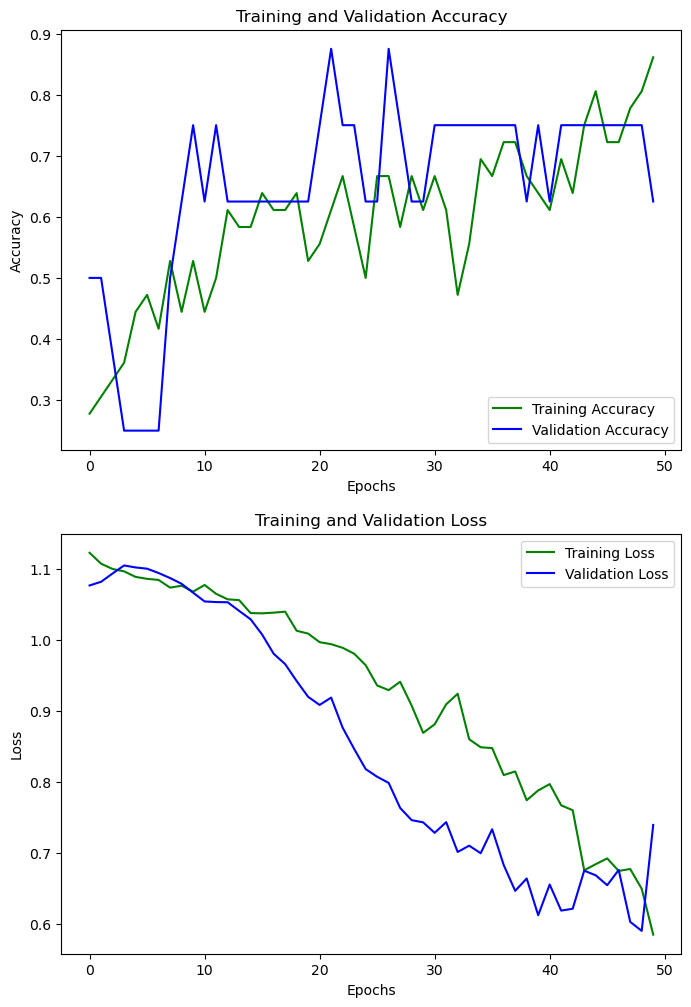

In [65]:
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_accuracy, "g", label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, "b", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, "g", label='Training Loss')
plt.plot(epochs_range, val_loss, "b", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
# save the model
import h5py

model.save('new_urgency-model.h5')


In [27]:
# save the tokenizer
import pickle

with open('new_urgency-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# evaluate the model and test on some new data 

loss, accuracy = model.evaluate(X_test_pad, y_test, batch_size=128)
print('Accuracy: %f' % (accuracy*100))

def test_model(test):
  # removes punctuation in the sentence
  test = re.sub(r'[^\w\s]', '', test)
  # gets all of the words in the sentence 
  words = word_tokenize(test)
  # converts all the words to lowercase
  words = [w.lower() for w in words]
  # retrieves a set of all of the stopwords in English 
  stop_words = set(stopwords.words('english'))
  # removes the stopwords in the sentence
  words = [w for w in words if not w in stop_words]


  sequences = tokenizer.texts_to_sequences([words])


  review_pad = pad_sequences(sequences, maxlen=100)
    
  encoding = ["critical", "warning", "info"]
  probabilities = model.predict(review_pad)
  prediction = np.argmax(probabilities)

  print('Sentence being analyzed by the model: ', test)
  print(f'Prediction: {encoding[prediction]} with probability {probabilities[0][prediction] * 100}%')


test_samples = ["You have to leave the building immediately", "Six people are in dire need of food", "You need to do your homework right now",
"You can walk your dog later today",
"Your dog urgently needs to go on a walk right now", "He is in need of a surgery", 
"25 people are reported as missing today",
"You can hand in your test when you feel like it", "the building is burning and they need assistance", "a hurricane has destroyed 50 homes", 
"The principal says that you need to come in for a meeting about your child's behavior", "The stagehand would like a break", 
"The worker wants to go on a vacation"] 

for test in test_samples:
  test_model(test)


AttributeError: 'FastText' object has no attribute 'evaluate'

# Ecommerce Dataset

In [ ]:
# Load the dataset
ecommerce_dataset = pd.read_csv("../ecommerceDataset.csv", names=["label", "description"])
ecommerce_dataset = ecommerce_dataset[["description", "label"]]

# Clean the data - drop duplicates and missing values
ecommerce_dataset.dropna(inplace=True)
ecommerce_dataset.drop_duplicates(inplace=True)
ecommerce_dataset.reset_index(drop=True, inplace=True)

# One hot encoding
ohe = pd.get_dummies(ecommerce_dataset["label"])
data = pd.concat([ecommerce_dataset["description"], ohe], axis=1)

ecommerce_dataset

In [54]:
# Text normalization
lines = data['description'].values.tolist()
ecommerce_cleaned_data = text_normalization(lines)

In [74]:
#get training, validation, and testing data 
VALIDATION_SPLIT = 0.2
max_length = 1000
sequences = tokenizer.texts_to_sequences(ecommerce_cleaned_data)

urgency_pad = pad_sequences(sequences, maxlen=max_length) # to later try - base length on mean value of sentence lengths 
label = np.array((data['Books'].values, data['Clothing & Accessories'].values, data['Electronics'].values, data['Household'].values)).T
print('Shape of urgency tensor:', urgency_pad.shape)
print('Shape of label tensor:', label.shape)

indices = np.arange(urgency_pad.shape[0])
np.random.shuffle(indices)
urgency_pad = urgency_pad[indices]
label = label[indices]
num_validation_samples = int(VALIDATION_SPLIT * urgency_pad.shape[0])

X_train_pad = urgency_pad[:-num_validation_samples]
y_train = label[:-num_validation_samples]
X_test_pad = urgency_pad[-num_validation_samples:]
y_test = label[-num_validation_samples:]

Shape of urgency tensor: (27802, 1000)
Shape of label tensor: (27802, 4)


In [75]:
# create an LSTM model 
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers import Embedding
from keras.initializers import Constant
import matplotlib.pyplot as plt

model = Sequential()
embedding_layer = Embedding(num_words,
                            60,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, batch_size=10, epochs=40, validation_data=(X_test_pad, y_test), verbose=2)

num_epochs = len(history.history['loss'])
epochs_range = range(0, num_epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

Summary of the built model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1000, 60)          9420      
                                                                 
 lstm_10 (LSTM)              (None, 32)                11904     
                                                                 
 dense_10 (Dense)            (None, 4)                 132       
                                                                 
Total params: 21,456
Trainable params: 12,036
Non-trainable params: 9,420
_________________________________________________________________
None
Epoch 1/40
223/223 - 174s - loss: 1.2729 - accuracy: 0.4060 - val_loss: 1.2248 - val_accuracy: 0.4344 - 174s/epoch - 778ms/step
Epoch 2/40
223/223 - 170s - loss: 1.2009 - accuracy: 0.4483 - val_loss: 1.1676 - val_accuracy: 0.4642 - 170s/epoch - 761ms/step
Epoch 3/40
223/223

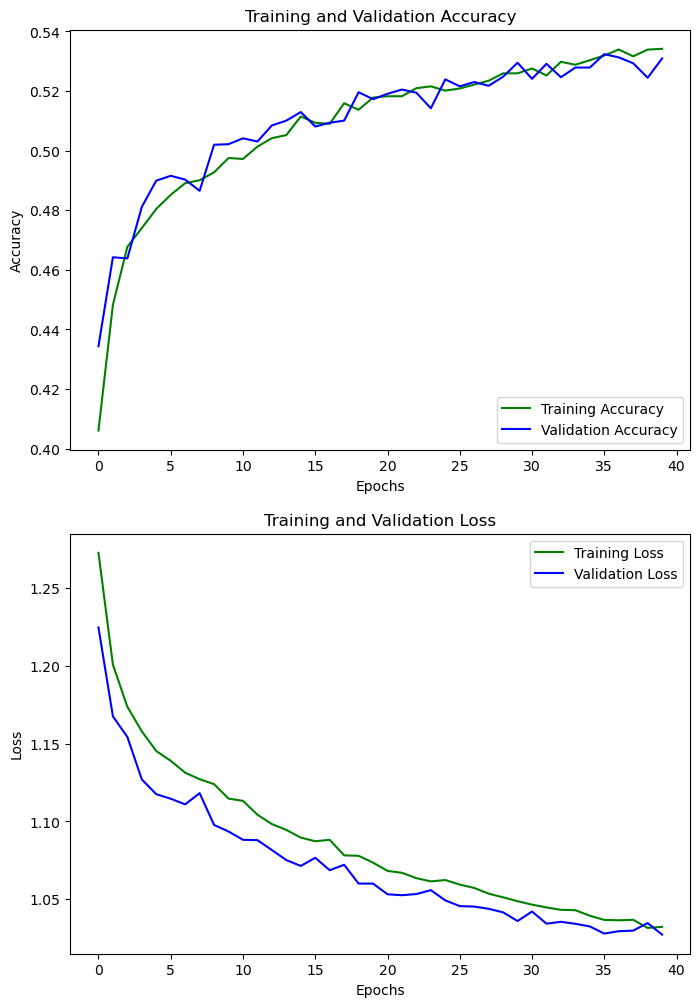

In [76]:
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_accuracy, "g", label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, "b", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, "g", label='Training Loss')
plt.plot(epochs_range, val_loss, "b", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# evaluate the model and test on some new data 

# loss, accuracy = model.evaluate(X_test_pad, y_test, batch_size=128)
# print('Accuracy: %f' % (accuracy*100))

def test_model(test):
  # removes punctuation in the sentence
  test = re.sub(r'[^\w\s]', '', test)
  # gets all of the words in the sentence 
  words = word_tokenize(test)
  # converts all the words to lowercase
  words = [w.lower() for w in words]
  # retrieves a set of all of the stopwords in English 
  stop_words = set(stopwords.words('english'))
  # removes the stopwords in the sentence
  words = [w for w in words if not w in stop_words]


  sequences = tokenizer.texts_to_sequences([words])


  review_pad = pad_sequences(sequences, maxlen=max_length)
    
  encoding = ["Books", "Clothing & Accessories", "Electronics", "Household"]
  probabilities = model.predict(review_pad)
  prediction = np.argmax(probabilities)

#   print('Sentence being analyzed by the model: ', test)
#   print(f'Prediction: {encoding[prediction]} with probability {probabilities[0][prediction] * 100}%')
  print(probabilities)

test_household = "Table Lamp with Pull Chain: The USB Bedside Table Lamp comes with a stylish pull chain to control the lamp, you can easy to turn on or turn off the light by pulling the chain, even in the darkness."
test_clothing = "A workwear staple, this men's pocket t-shirt is equal parts durable and comfortable. It has an original fit, Carhartt's roomiest cut. The heavyweight fabric only gets softer with time."
test_books = "NEW YORK TIMES BESTSELLER • The epic tale of a woman who breathes a fantastical empire into existence, only to be consumed by it over the centuries—from the transcendent imagination of Booker Prize–winning, internationally bestselling author Salman Rushdie"
test_electronics = "Dominate on a different scale with the Razer Huntsman Mini TKL — a 60% gaming keyboard with cutting-edge Razer Clicky Optical Switches. Highly portable and ideal for streamlined setups, it’s time to experience lightning-fast actuation in our most compact form factor yet."

test_samples = [test_household, test_clothing, test_books, test_electronics] 

for test in test_samples:
  test_model(test)
